<a href="https://colab.research.google.com/github/rishabhk0/end_to_end_ml/blob/Drowsiness_Detection_OpenCV/train_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [12]:
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Downloading the Dataset

In [2]:
os.environ['KAGGLE_USERNAME'] =   "rishabhkarnawat99"
os.environ['KAGGLE_KEY'] = "KGAT_b9ec9fab04cf1a79a2611e9e880dbabd"

!kaggle datasets download -d prasadvpatil/mrl-dataset

Dataset URL: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset
License(s): CC0-1.0
  0% 0.00/22.6M [00:00<?, ?B/s]
100% 22.6M/22.6M [00:00<00:00, 1.62GB/s]


In [3]:
zip_path = "mrl-dataset.zip"
extract_path = "mrl_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: mrl_dataset


# Reading the Data

In [4]:
print("Folders:")
for folder in os.listdir(extract_path):
    if os.path.isdir(os.path.join(extract_path, folder)):
        print(folder)


Folders:
train


In [5]:
classes = os.listdir(extract_path)
corrupted_count = 0

for cls in classes:
    class_path = os.path.join(extract_path, cls)

    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)


        if os.path.isfile(img_path):
            try:
                Image.open(img_path).verify()
            except:
                print(f"Deleting corrupted image: {img_path}")
                os.remove(img_path)
                corrupted_count += 1

        elif os.path.isdir(img_path):
            print(f"Skipping directory: {img_path}")

print("Classes:", classes)
print("Number of corrupted images deleted:", corrupted_count)

Skipping directory: mrl_dataset/train/Closed_Eyes
Skipping directory: mrl_dataset/train/Open_Eyes
Classes: ['train']
Number of corrupted images deleted: 0


# Data Visualization

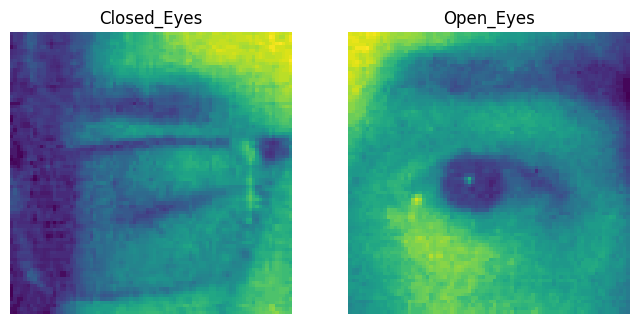

In [6]:
train_path = os.path.join(extract_path, 'train')
class_dirs = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

plt.figure(figsize=(8, 4))

for i, class_name in enumerate(class_dirs):
    class_path = os.path.join(train_path, class_name)


    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    if not image_files:
        print(f"No images found in {class_path}, skipping.")
        continue

    img_name = random.choice(image_files)
    img_path = os.path.join(class_path, img_name)

    img = Image.open(img_path)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()

# Generating Image

In [15]:


IMG_SIZE = 24
BATCH_SIZE = 32
EPOCHS = 20

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'mrl_dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'mrl_dataset/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation=LeakyReLU()),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation=LeakyReLU()),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation=LeakyReLU()),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_drowsiness_model.h5",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    factor=0.5,
    patience=3,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

model.save("best_drowsiness_model.h5")

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8159 - loss: 0.3931
Epoch 1: val_loss improved from inf to 0.40359, saving model to best_drowsiness_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8185 - loss: 0.3879 - val_accuracy: 0.9275 - val_loss: 0.4036 - learning_rate: 0.0010
Epoch 2/20
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9835 - loss: 0.0498
Epoch 2: val_loss did not improve from 0.40359
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9838 - loss: 0.0492 - val_accuracy: 0.9275 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 3/20
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9940 - loss: 0.0227
Epoch 3: val_loss did not improve from 0.40359
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9939 - loss: 0.0229 - val_accuracy: 0.9212 - val_loss: 0.5232 - learning_rate: 0.0010
Epoch 4/20
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9983 - loss: 0.0077
Epoch 4: val_loss did not improve from 0.40359

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9982 - loss: 0.0077 - val_accuracy: 0.8

# Plots

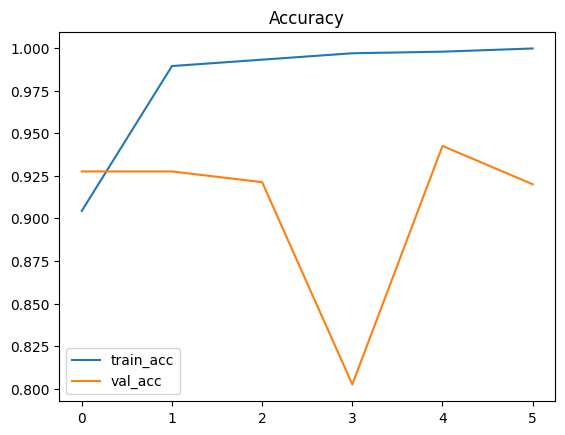

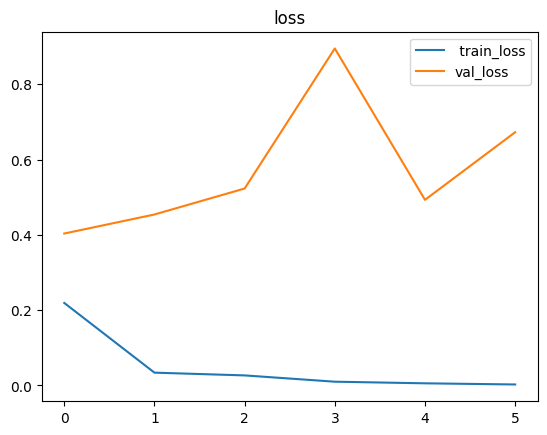

Training Complete, Best Model saved as best_drowsiness.h5


In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label ='train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.title("Accuracy")
plt.show()


plt.figure()
plt.plot(history.history['loss'], label = ' train_loss')
plt.plot(history.history['val_loss'], label ='val_loss')
plt.legend()
plt.title("loss")
plt.show()

print("Training Complete, Best Model saved as best_drowsiness.h5")